In [101]:
import numpy as np

# import qutip as qt
import torch
from torch.utils.data import Dataset, DataLoader
import joblib

import torch.nn as nn
import matplotlib.pyplot as plt

from torch import tensor

from tqdm.notebook import tqdm
import torch_optimizer as topt

In [102]:
def create_windowed_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset) - lookback):
        feature = dataset[i : i + lookback]
        target = dataset[i + lookback]
        X.append(feature)
        y.append(target)
    return torch.stack(X), torch.stack(y)

In [103]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [104]:
raw_data = joblib.load("raw_data.job").real.swapaxes(1, 2)

In [105]:
num_epochs = 5000  # Number of training epochs
N = raw_data.shape[0]
C = raw_data.shape[1]
L = raw_data.shape[2]

no_filters = 64

kernel_window = 1

number_of_features = 4

torch.autograd.set_detect_anomaly(False)


opt_list = [torch.optim.Adam]

X_raw = raw_data[:, :, ::100][:, :, :]
y_raw = raw_data[:, :, ::100][:, :, :][:, :, kernel_window - 1 :]


X_raw_windowed, y_raw_windowed = torch.vmap(
    lambda df: create_windowed_dataset(df, lookback=kernel_window)
)(tensor(raw_data[:, :, ::100].swapaxes(1, 2)))


X_raw_windowed = X_raw_windowed.swapaxes(2, 3)
# y_raw_windowed = y_raw_windowed.swapaxes(2, 3)

print(
    f"The shape of X_raw_windowed is:\n [no_samples, all_windows, no_features, window_size]: {X_raw_windowed.shape}"
)

print(
    "We don't care anymore about the independent trajectories (well maybe for checking visually) \nso we can merge the first two axes"
)


X_raw_windowed_merged_trajs = X_raw_windowed.reshape(
    -1, number_of_features, kernel_window
)

y_raw_windowed_merged_trajs = y_raw_windowed.reshape(-1, number_of_features)

The shape of X_raw_windowed is:
 [no_samples, all_windows, no_features, window_size]: torch.Size([1000, 49, 4, 1])
We don't care anymore about the independent trajectories (well maybe for checking visually) 
so we can merge the first two axes


In [106]:
X_raw_windowed.shape

torch.Size([1000, 49, 4, 1])

In [107]:
y_raw.shape

(1000, 4, 50)

In [108]:
y_raw_windowed.shape

torch.Size([1000, 49, 4])

In [109]:
y_raw_windowed_merged_trajs.shape

torch.Size([49000, 4])

In [110]:
class CNNDensityMatrix(nn.Module):
    def __init__(
        self, no_channels, no_filters, kernel_window, timeseries_length=None
    ):
        super(CNNDensityMatrix, self).__init__()
        self.kernel_window = kernel_window
        self.conv1 = nn.Conv1d(
            in_channels=no_channels,
            out_channels=no_filters,
            kernel_size=kernel_window,
        )
        # self.fc0 = nn.Linear(kernel_window*no_channels, no_filters)
        self.fc1 = nn.Linear(no_filters, 512)
        self.fc2 = nn.Linear(512, no_channels)

    def forward(self, x):
        # x is of shape torch.Size([batch_size, num_features, kernel_window])

        # Apply convolution to the window
        aux = self.conv1(x).squeeze(-1)
        aux = nn.ReLU()(aux)
        # print(x.shape)
        # aux = self.fc0(x.flatten(-1))
        # aux = nn.ReLU()(aux)
        # Permute and apply fully connected layer
        # print(aux.shape)
        aux = self.fc1(aux)
        aux = nn.ReLU()(aux)
        aux = self.fc2(aux)

        # Squeeze the last dimension to remove the window size
        # output = aux.squeeze(-1)
        return aux


class DensityMatrixDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        sample = (self.X[idx], self.y[idx])
        return sample

In [111]:
# Split training and validation data
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_raw_windowed_merged_trajs,
    y_raw_windowed_merged_trajs,
    test_size=0.2,
    random_state=42,
)

In [112]:
X_train.shape

torch.Size([39200, 4, 1])

In [113]:
def generate_sequence(model, initial_window, sequence_length):
    """
    Generates a sequence of the specified length using the given model and initial window.

    Args:
        model (YourModel): The trained model instance.
        initial_window (torch.Tensor): The initial window to start generating the sequence.
                                       Shape should be (batch_size, num_features, kernel_window).
        sequence_length (int): The total length of the sequence to be generated.

    Returns:
        torch.Tensor: The generated sequence of shape (batch_size, num_features, sequence_length).
    """
    batch_size, num_features, kernel_window = initial_window.shape
    # Preallocate output tensor with the correct size
    final_output = torch.empty(
        (batch_size, num_features, sequence_length),
        device=initial_window.device,
    )

    # Fill in the initial part of the output sequence
    final_output[:, :, :kernel_window] = initial_window

    # Generate the rest of the sequence
    current_window = initial_window
    for i in range(sequence_length - kernel_window):
        # Get the model output for the current window
        output = model(current_window)

        # Place the output in the preallocated tensor
        final_output[:, :, i + kernel_window] = output

        # Update the current window by sliding one step forward
        current_window = torch.cat(
            (current_window[:, :, 1:], output.unsqueeze(-1)), dim=2
        )

    return final_output

In [ ]:
dataset = DensityMatrixDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=len(X_train), shuffle=True)

test_dataset = DensityMatrixDataset(X_val, y_val)
test_dataloader = DataLoader(test_dataset, batch_size=len(X_val), shuffle=True)


model = CNNDensityMatrix(
    no_channels=C,
    no_filters=no_filters,
    kernel_window=kernel_window,
    timeseries_length=L,
)

model = model.to(device)


criterion = lambda y_hat, y_true: nn.L1Loss()(y_hat, y_true) + nn.MSELoss()(
    y_hat, y_true
)

optimizer = topt.DiffGrad(model.parameters(), lr=0.01)

In [ ]:
print(model)

CNNDensityMatrix(
  (conv1): Conv1d(4, 64, kernel_size=(1,), stride=(1,))
  (fc1): Linear(in_features=64, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=4, bias=True)
)


In [ ]:
X_temp, y_temp = next(iter(dataloader))

In [ ]:
X_temp = X_temp.to(device)

print(X_temp[:, :, :kernel_window].shape)

print(X_temp.shape)

print(model(X_temp[:, :, :kernel_window]).shape)
y_temp.shape

torch.Size([39200, 4, 1])
torch.Size([39200, 4, 1])
torch.Size([39200, 4])


torch.Size([39200, 4])

In [ ]:
y_val.shape

torch.Size([9800, 4])

In [ ]:
model(X_val.to(device)).shape

torch.Size([9800, 4])

In [ ]:
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, epochs=num_epochs, steps_per_epoch=len(dataloader))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.5, patience=200, verbose=True, threshold=1e-16
)
progress_bar = tqdm(range(num_epochs), desc="Epoch")
minloss = 100
for epoch in progress_bar:
    running_loss = 0.0
    # progress_bar_epoch = tqdm(dataloader, desc='Batch')
    for i, data in enumerate(dataloader):
        X, y_true = data
        # y_true = X
        X = X.to(device)
        y_true = y_true.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        y_hat = model(X)

        # y_hat = generate_sequence(model, X[:,:,:kernel_window], X.shape[2])

        # Concatenate all outputs to get the final sequence
        # print(y_true.shape, y_hat.shape)
        # d0_loss = criterion(y_true, y_hat[:,:,kernel_window-1:])

        d0_loss = criterion(y_hat, y_true)
        # ft_loss = criterion(torch.fft.rfft(y_true).abs()[:,:,:10] , torch.fft.rfft(y_hat[:,:,kernel_window-1:]).abs()[:,:,:10] )

        loss = d0_loss  # + ft_loss*0.1
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Print statistics
        # running_loss += loss.item()

        # if i % 10 == 9:  # Print every 10 mini-batches
        # print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 10:.3e}")
        # minloss = running_loss if running_loss < minloss else minloss
        # running_loss = 0.0 if i!=(num_epochs-1) else running_loss
        # progress_bar_epoch.set_postfix(loss="{:.3e}".format(loss.item()))

    all_true = X_val

    y_hat_validation = model(X_val.to(device))

    val_loss = criterion(y_hat_validation, y_val.to(device))

    # all_preds = generate_sequence(model, tensor(X_val[:,:,:kernel_window]).to(device), X_val.shape[2]).clone().detach().cpu()
    # val_loss = criterion(tensor(all_true), tensor(all_preds))
    scheduler.step(val_loss)
    progress_bar.set_postfix(loss="{:.3e}".format(val_loss.item()))

/home/antonio/miniconda3/envs/torch/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x71ed0571f170>>
Traceback (most recent call last):
  File "/home/antonio/miniconda3/envs/torch/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


KeyboardInterrupt: 

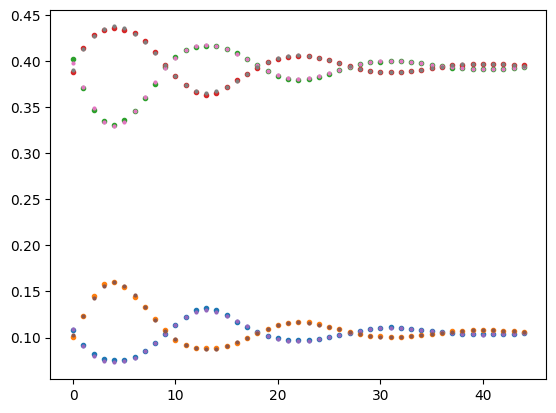

In [ ]:
i = np.random.randint(0, 20 - 1)


plt.plot(model(X_raw_windowed[i].to(device)).cpu().detach().numpy(), '.', label= "predicted", ms=6)
plt.plot(y_raw_windowed[i], '.', label="True", ms=4)


In [ ]:
X_raw.shape

(1000, 4, 50)

In [ ]:
all_preds = (
    generate_sequence(
        model, tensor(X_raw[:, :, :kernel_window]).to(device), X_raw.shape[2]
    )
    .detach()
    .cpu()
    .numpy()
)

In [ ]:
# all_preds = (
#     generate_sequence(
#         model, tensor(X_val[:, :, :kernel_window]).to(device), X_val.shape[2]
#     )
#     .detach()
#     .cpu()
#     .numpy()
# )

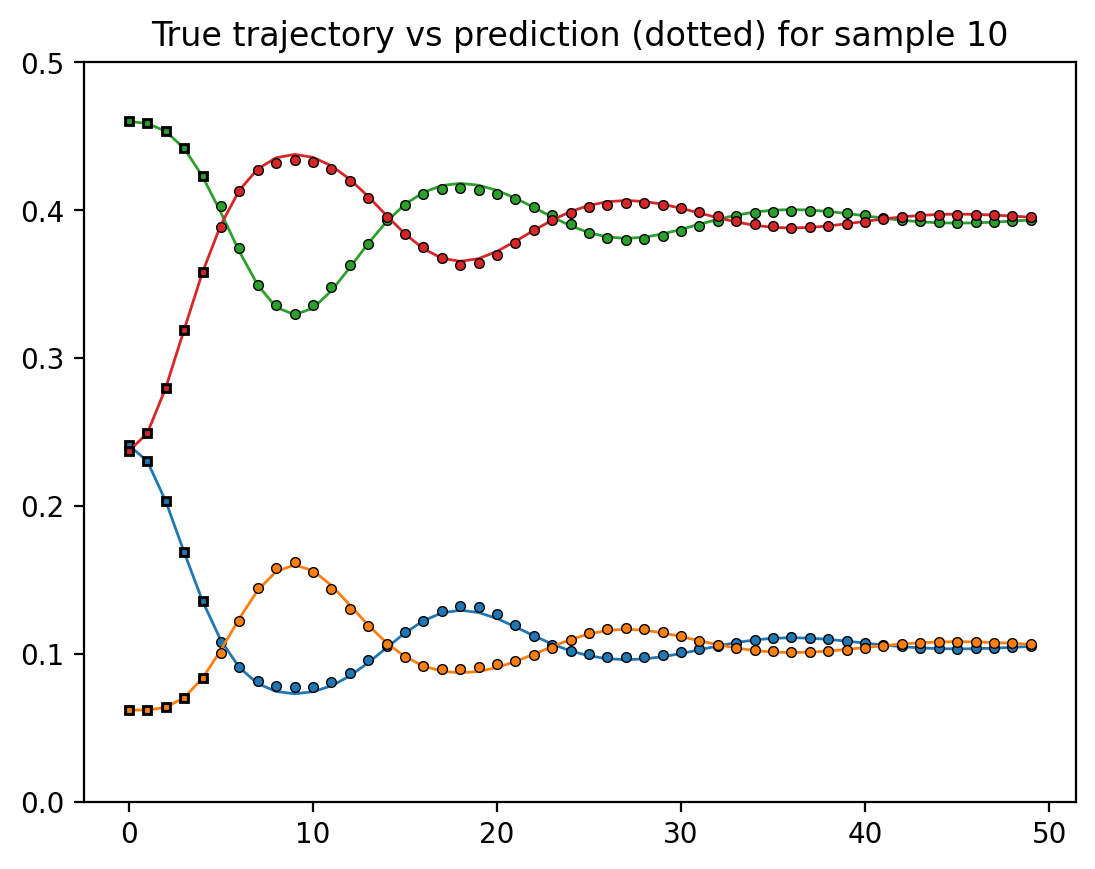

In [ ]:
# all_preds = model(tensor(X_val).to(device)).cpu().detach().numpy()

i = np.random.randint(0, 20 - 1)

plt.figure(dpi=200)
for j in range(all_true.shape[1]):
    plt.plot(X_raw[i][j], color=f"C{j}", lw=1)

    plt.plot(
        range(kernel_window),
        all_preds[i][j][:kernel_window],
        "s",
        color=f"k",
        ms=3,
    )
    plt.plot(
        range(kernel_window),
        all_preds[i][j][:kernel_window],
        "s",
        color=f"C{j}",
        ms=1,
    )

    plt.plot(
        range(kernel_window, len(all_preds[i][j])),
        all_preds[i][j][kernel_window:],
        ".",
        color=f"k",
        ms=6,
    )
    plt.plot(
        range(kernel_window, len(all_preds[i][j])),
        all_preds[i][j][kernel_window:],
        ".",
        color=f"C{j}",
        ms=4,
    )

    plt.ylim(0, 0.5)
plt.title(f"True trajectory vs prediction (dotted) for sample {i}")
plt.show()

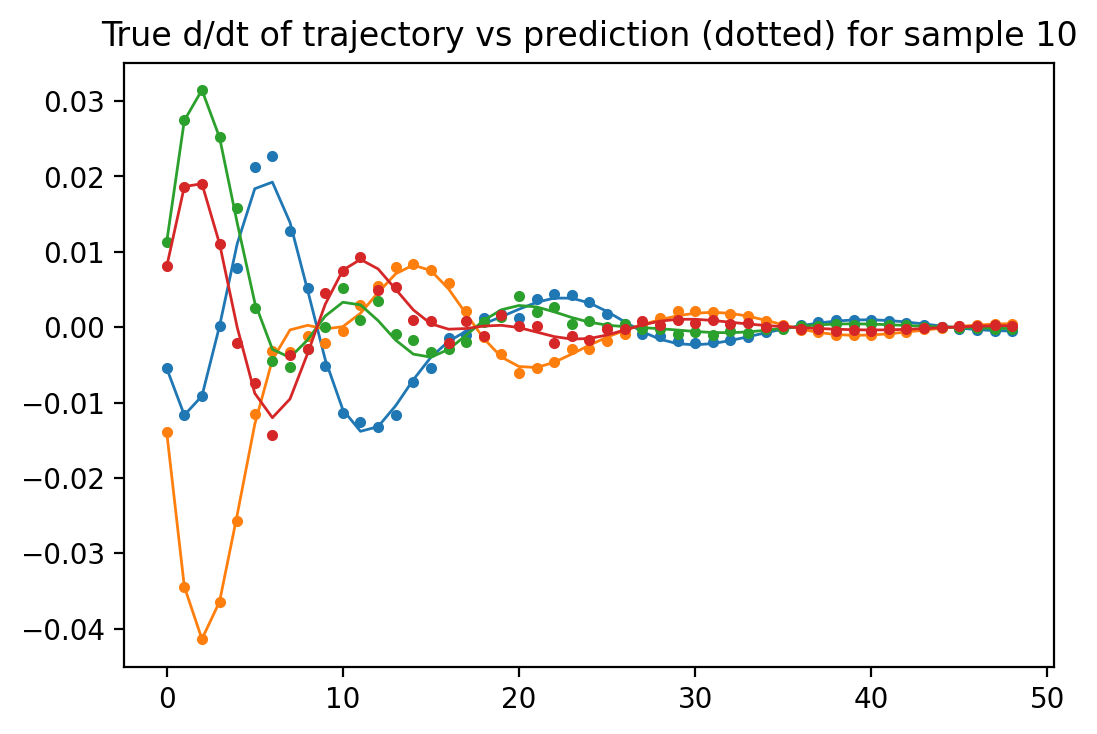

In [ ]:
# all_preds = model(tensor(X_val).to(device)).cpu().detach().numpy()
i = np.random.randint(0, 20 - 1)

plt.figure(dpi=200)
for j in range(all_true.shape[1]):
    plt.plot(np.diff(X_val[i][j]), color=f"C{j}", lw=1)
    plt.plot(np.diff(all_preds[i][j]), ".", color=f"C{j}")
    # plt.ylim(0,1)
plt.title(f"True d/dt of trajectory vs prediction (dotted) for sample {i}")
plt.show()

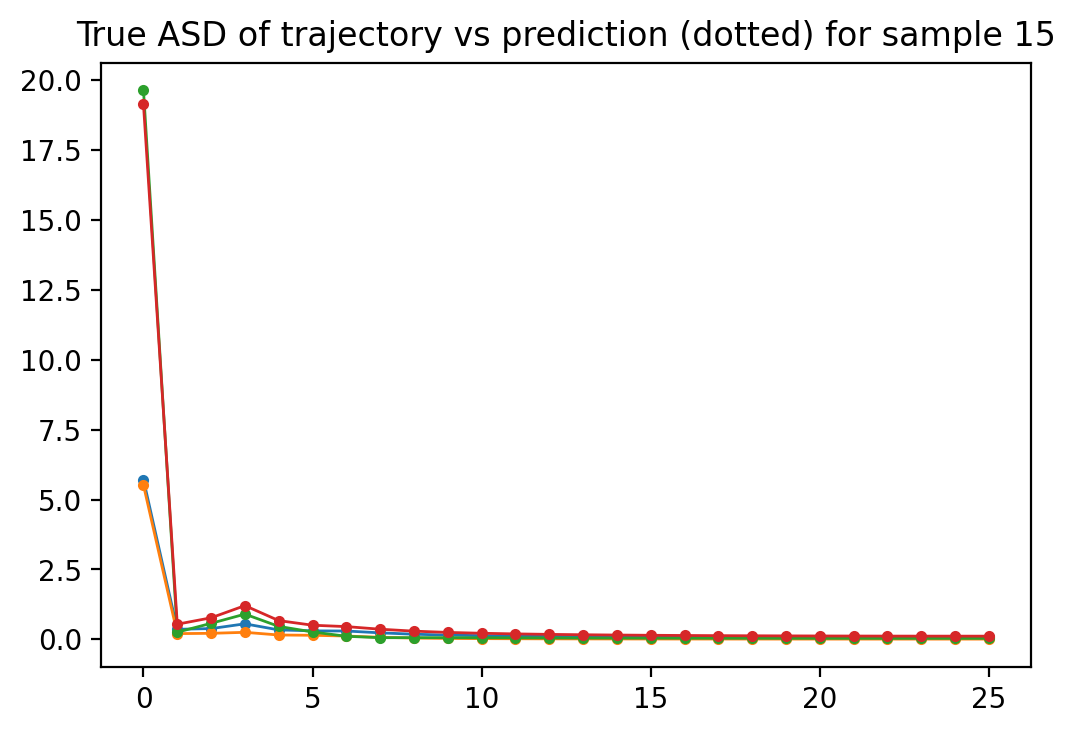

In [ ]:
# all_preds = model(tensor(X_val).to(device)).cpu().detach().numpy()
i = np.random.randint(0, 20 - 1)

plt.figure(dpi=200)
for j in range(all_true.shape[1]):
    plt.plot(abs(np.fft.rfft(X_val[i][j])), color=f"C{j}", lw=1)
    plt.plot(abs(np.fft.rfft(all_preds[i][j])), ".", color=f"C{j}")
    # plt.ylim(0,1)
plt.title(f"True ASD of trajectory vs prediction (dotted) for sample {i}")
plt.show()